In [11]:
%load_ext autoreload
%autoreload 2

In [12]:
import pandas as pd
import numpy as np
from pathlib import Path
from tools.record_tools import complete_records
import seaborn as sns
from scipy.stats import entropy
from collections import defaultdict
from collections import Counter
import matplotlib.pyplot as plt
from scipy.stats import entropy
sns.set()

In [27]:

path = Path('output_data/MPD_export_1846_1920.csv')
df = pd.read_csv(path,index_col=0)
print(df[~df['S-POL'].isnull()].shape)
df = complete_records(df,'S-POL')
print(df[~df['S-POL'].isnull()].shape)


(36548, 19)
(38050, 20)


In [10]:
df_prov = df[df['CATEGORY'].isin(['provincial','welsh','scottish'])]
df_prov = df_prov[df_prov.year <= 1900]
df_prov.shape

(24159, 20)

# Distribution of labels

In [11]:
len(df_prov['S-POL'].unique())

71

In [12]:
labels = set(i.strip() for l in df_prov['S-POL'].unique() for i in str(l).split(';'))
len(labels)

34

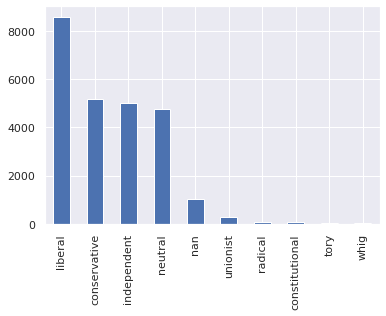

In [67]:
pd.Series(dict(Counter(i.strip() for l in df_prov['S-POL'] for i in str(l).split(';')).most_common()[:10])).plot(kind='bar')

# Switching labels

In [14]:
df_prov_chained = df_prov[~df_prov.chain_id.isnull()]
pol_set = df_prov_chained.groupby('chain_id')['S-POL'].apply(lambda x: len(set(x)))

In [33]:
pol_set_content = df_prov_chained.groupby('chain_id')['S-POL'].apply(lambda x: set(x))
pol_set_content

chain_id
CID_000002                                 {liberal}
CID_000003                                 {liberal}
CID_000004                                 {liberal}
CID_000005                                 {neutral}
CID_000006    {conservative, conservative; unionist}
                               ...                  
CID_005453                                 {neutral}
CID_005454                             {independent}
CID_005455                             {independent}
CID_005456                                     {nan}
CID_005457                                 {neutral}
Name: S-POL, Length: 3497, dtype: object

Index(['CID_000002', 'CID_000015', 'CID_000030', 'CID_000110', 'CID_000006',
       'CID_000052', 'CID_000107', 'CID_000050', 'CID_000035', 'CID_000008',
       ...
       'CID_003402', 'CID_002955', 'CID_001553', 'CID_003417', 'CID_002974',
       'CID_002995', 'CID_003355', 'CID_002557', 'CID_003420', 'CID_002981'],
      dtype='object', length=3497)

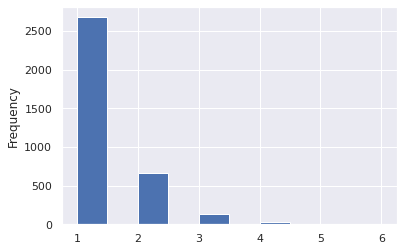

In [15]:
pol_set.plot(kind='hist')

In [16]:
sum(pol_set > 1) / pol_set.shape[0]

0.23477266228195595

In [17]:
chain_id_counts = df_prov_chained.chain_id.value_counts()


In [22]:
pol_set = df_prov_chained[df_prov_chained.chain_id.isin((chain_id_counts[chain_id_counts] > 3).index)].groupby('chain_id')['S-POL'].apply(lambda x: len(set(x)))


In [23]:
sum(pol_set > 1) / pol_set.shape[0]

0.4090909090909091

# Changes over time

In [21]:
df_prov_chained = df_prov[~df_prov.chain_id.isnull()]

In [62]:
yeardict = defaultdict(list)
import copy

for ch in df_prov_chained.chain_id.unique():
    df_pivot = df_prov_chained[df_prov_chained.chain_id==ch]
    df_pivot.reset_index(inplace=True)
    pol_id = '#'
    #print(df_pivot.shape)
    for i,row in df_pivot.iterrows():
        
        if (i > 0) and (pol_id != row['S-POL']): 
            yeardict[row.year].append(f"{pol_id} -> {row['S-POL']}")
        pol_id = row['S-POL']
        

In [64]:
count_switches = Counter([i for k, v in yeardict.items() for i in v]).most_common(20)

In [83]:
families = ['liberal', 'conservative','neutral','independent', 'unionist']
count_by_family = defaultdict(int)
for k,v in count_switches:
    for f in families:
        if f in k.split("->")[1]: count_by_family[f]+=v



In [84]:
count_by_family

defaultdict(int,
            {'liberal': 297,
             'independent': 237,
             'conservative': 221,
             'neutral': 94,
             'unionist': 48})

In [85]:
label_counts = dict(Counter(i.strip() for l in df_prov_chained['S-POL'] for i in str(l).split(';')))

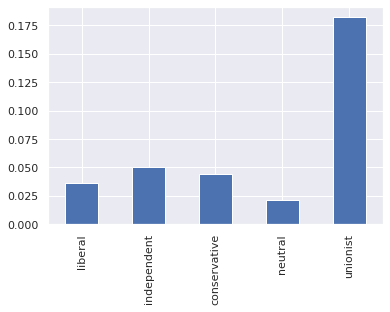

In [86]:
pd.Series({f: count_by_family[f] / label_counts[f] for f in count_by_family.keys()}).plot(kind='bar')

# Sample - Population comparison

In [14]:
path = Path('output_data/MPD_export_1846_1920_JISC.csv')
df = pd.read_csv(path,index_col=0)
df = complete_records(df,'S-POL')
df['IN_JISC'] = False
df.loc[~df['JISC'].isnull(),'IN_JISC'] = True
df_prov = df[df['CATEGORY'].isin(['provincial','welsh','scottish'])]
df_prov = df_prov[df_prov.year <= 1900]
df_prov.reset_index(inplace=True)
df_prov.shape

(24159, 23)

## Group labels

In [15]:
print(set(s.strip() for p in df_prov['S-POL'].unique() for s in str(p).split(';')))

{'free-trade', 'national', 'neutral', 'radical', 'no-politics', 'ultra', 'evangelical', 'conservative', 'catholic', 'nan', 'independent', 'unionist', 'progressive', 'roman-catholic', 'liberal', 'whig', 'industrial', 'chartist', 'labour', 'nationalist', 'church-of-england', 'irish', 'roman', 'democratic', 'tory', 'advanced', 'non-political', 'protestant', 'old', 'constitutional', 'li', 'non-comformist', 'moderate', 'non-party'}


In [16]:
has_label = lambda x, labels: 1 if set([i.strip() for i in str(x).split(';')]).intersection(set(labels)) else 0

cat2labels = {'liberal':['liberal','whig','li'],
              'conservative':['conservative','tory'],
              'neutral':['neutral','non-party','non-political','no-politics'],
              'independent':['independent'],
              'neutral_independent': ['neutral','non-party','non-political','no-politics','independent'],
              'nationalist':['national','nationalist'],
              'unionist':['unionist'],
              'religious':['roman-catholic','evangelical','catholic','protestant','non-comformist','church-of-england'],
              'radical':['chartist','labour','radical','progressive','democratic','ultra','advanced'],
              'nan':['nan']}

In [17]:
for c, labels in cat2labels.items():
    for l in labels:
        df_prov[c] = df_prov['S-POL'].apply(has_label,labels=labels)


In [18]:
counts_by_year = df_prov.groupby(['year'])['id'].count()
counts_by_year_jisc = df_prov[df_prov.IN_JISC==True].groupby(['year'])['id'].count()


In [19]:


def plot_comparison_selected_categories(selected,df):
    
    fig, ax = plt.subplots(figsize=(8,6))
    maximums = []
    for label,color in selected:
        pv = df.groupby('year')[label].mean()
        pv_jisc = df[df['IN_JISC']==True].groupby('year')[label].mean()
        maximums.extend([pv.max(),pv_jisc.max()])
        
        
        ax.plot(pv.index, pv, color=color, marker="s", linestyle= '--',linewidth=2, markersize=6,alpha=0.5)
        ax.plot(pv_jisc.index, pv_jisc, color=color, marker="x", 
                                linestyle='-.', linewidth=2, markersize=6, alpha=0.75)
    ax.set_ylim(
            [0, np.max(maximums)+0.05]
        )
    plt.show()


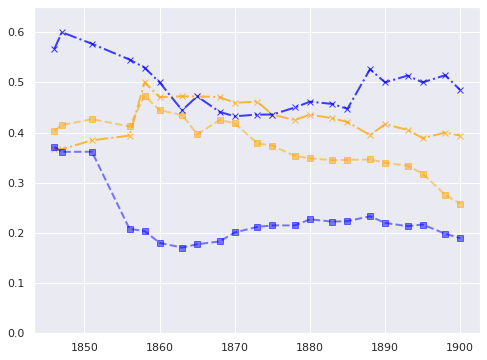

In [20]:
plot_comparison_selected_categories([("liberal",'orange'),("conservative","blue")],df_prov)


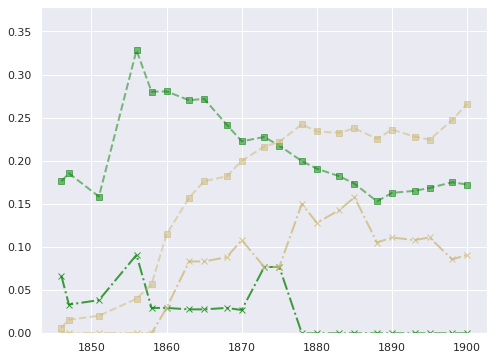

In [21]:
plot_comparison_selected_categories([("neutral",'green'),("independent","y")],df_prov)

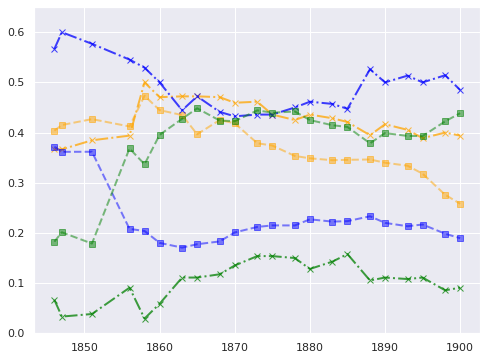

In [22]:
plot_comparison_selected_categories([("liberal",'orange'),("conservative","blue"),('neutral_independent','green')],df_prov)

## Divergence

In [190]:
def kl_divergence(df, labels, smoothing_factor):
    df['num_pol_labels'] = df['S-POL'].apply(lambda x: len(str(x).split(';')))
    pol_labels_all = df.groupby('year')['num_pol_labels'].sum()
    pol_labels_jisc = df[df.IN_JISC==True].groupby('year')['num_pol_labels'].sum()

    dfs_jisc, dfs_all = [], []
    for l in labels: 
        dfs_jisc.append(df[df.IN_JISC==True].groupby('year')[l].sum())
        dfs_all.append(df.groupby('year')[l].sum())

    
    
    dfs_jisc = pd.concat(dfs_jisc,axis=1)
    dfs_all = pd.concat(dfs_all,axis=1)

    #dfs_all['other'] = pol_labels_all - dfs_all.sum(axis=1)
    #dfs_jisc['other'] = pol_labels_jisc - dfs_jisc.sum(axis=1)


    df_probs_jisc = dfs_jisc.divide(pol_labels_jisc,axis=0)
    df_probs_jisc = (df_probs_jisc + smoothing_factor
                        ).divide(
                            (df_probs_jisc+smoothing_factor).sum(axis=1), axis=0) 

    df_probs_all = dfs_all.divide(pol_labels_all,axis=0)
    df_probs_all = (df_probs_all + smoothing_factor
                        ).divide(
                            (df_probs_all+smoothing_factor).sum(axis=1), axis=0)

    entropies = {}
    for year in dfs_all.index:
        entropies[year] = entropy(df_probs_all.loc[year],df_probs_jisc.loc[year])


    return pd.DataFrame.from_dict(entropies,orient='index')

In [191]:

def plot_kl_divergence(labels,smoothing_factors):
    results = []
    for sm in smoothing_factors:
        results.append(kl_divergence(df_prov, labels, sm))
    df_results = pd.concat(results,axis=1)
    df_results.columns = smoothing_factors
    df_results.plot() 
#plot_kl_divergence(df_prov, ['liberal','conservative','neutral_independent'], 0.001)

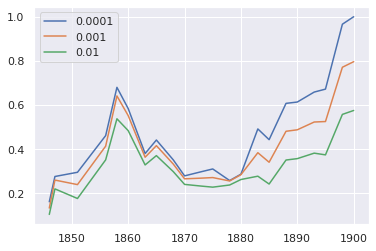

In [197]:
plot_kl_divergence(['liberal','conservative','neutral_independent','nan'], [0.0001,0.001,0.01])

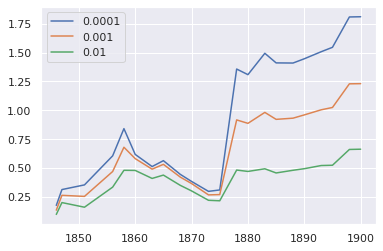

In [199]:
plot_kl_divergence(['liberal','conservative','neutral','independent','unionist','nan'], [0.0001,0.001,0.01])